In [1]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)


C:\Users\hjagirdar\AppData\Local\Temp\ipykernel_2668\4011481925.py:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)
C:\Users\hjagirdar\AppData\Local\Temp\ipykernel_2668\4011481925.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)


In [2]:

print(len(df.loc[df['Outcome'] =='DEFERRAL']))  # number of deferrals
print(len(df))#total observations


df.head()

556068
5115926


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo
0,1887945,2017-10-23 00:00:00.000,2017.0,10.0,1345.0,2.0,3622.0,26.0,F,Mobile Clinic,...,4,African Black,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
1,1565252,2021-05-31 00:00:00.000,2021.0,5.0,1435.0,40.0,69.0,44.5,M,Mobile Clinic,...,2,Asian,24.9,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
2,2299175,2015-03-10 00:00:00.000,2015.0,3.0,1445.0,6.0,140.0,19.6,M,Mobile Clinic,...,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
3,2820016,2019-03-18 00:00:00.000,2019.0,3.0,1805.0,3.0,748.0,20.3,F,Mobile Clinic,...,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
4,3450551,2022-09-06 00:00:00.000,2022.0,9.0,1336.0,3.0,951.0,20.5,M,Mobile Clinic,...,4,African Black,83.8,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN


In [3]:
#add donor history variables (already created and stored in don_hist.csv)
#see cox_params.xls for more information
df['Visit_Date']=pd.to_datetime(df['Visit_Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ') #covert to ISO -#2019-03-26T00:00:00Z

don_hist=pd.read_csv("../1_data/private/don_hist.csv")
df=pd.merge(df, don_hist[['DonorID', 'Visit_Date','cum_lifetime_donations','unit_rbc_loss','time_to_fu',
                          'rbc_loss_last_12_months', 'rbc_loss_last_24_months','days_since_last_rbc_loss', 
                          'days_since_last_drbc_loss']], how='left', on=["DonorID", "Visit_Date"])

df.head()

C:\Users\hjagirdar\AppData\Local\Temp\ipykernel_2668\4182776018.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  don_hist=pd.read_csv("../1_data/private/don_hist.csv")


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss
0,1887945,2017-10-23T00:00:00Z,2017.0,10.0,1345.0,2.0,3622.0,26.0,F,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1565252,2021-05-31T00:00:00Z,2021.0,5.0,1435.0,40.0,69.0,44.5,M,Mobile Clinic,...,NoDeferral,NaN,NaN,40.0,1.0,119.0,2.0,3.0,69.0,3650.0
2,2299175,2015-03-10T00:00:00Z,2015.0,3.0,1445.0,6.0,140.0,19.6,M,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2820016,2019-03-18T00:00:00Z,2019.0,3.0,1805.0,3.0,748.0,20.3,F,Mobile Clinic,...,NoDeferral,NaN,NaN,3.0,1.0,267.0,1.0,1.0,748.0,3650.0
4,3450551,2022-09-06T00:00:00Z,2022.0,9.0,1336.0,3.0,951.0,20.5,M,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[(df['Outcome'] == 'DEFERRAL') & (df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object

df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)

df['OUTCOME_TYPE'].value_counts()

completed         4451108
other deferral     308593
low hgb            247475
no draw            108748
Name: OUTCOME_TYPE, dtype: int64

In [5]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-31

df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 31)-df["Visit_Date"])/np.timedelta64(1, 'D'))
#df['time_to_return'].fillna((df['VISIT_DATE'].shift(-1)-df["VISIT_DATE"])/np.timedelta64(1, 'D'), inplace=True)

#dfhgb=df.query("OUTCOME_TYPE == 'low hgb'")
pd.set_option('display.max_columns', 48)
df.head()


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,MobileID,donation_product,DonProc,Outcome,ABO_RH,Disease_marker_results,HB_Value,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,OUTCOME_TYPE,CENSORED,time_to_return
2758498,18353,2015-07-07,2015.0,7.0,1453.0,20.0,521.0,38.9,M,Fixed Clinic,FJD003,WB,WHOLE BLOOD,SUCCESSFUL DONATION,OPOS,NEG,NaN,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,completed,1,67.0
620072,18353,2015-09-12,2015.0,9.0,1050.0,21.0,67.0,39.1,M,Fixed Clinic,FJD003,WB,WHOLE BLOOD,SUCCESSFUL DONATION,OPOS,NEG,NaN,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,completed,1,304.0
1973711,18353,2016-07-12,2016.0,7.0,951.0,21.0,67.0,39.9,M,Fixed Clinic,FJD003,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,17.0,1,White,0.0,Medical Diagnosis/Procedure,Ta003 - Tachycardia (1 day),2016-07-12 00:00:00.000,2016-07-13 00:00:00.000,Temp,2016.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other deferral,1,1.0
1532484,18353,2016-07-13,2016.0,7.0,1143.0,21.0,67.0,39.9,M,Fixed Clinic,FJD001,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,NaN,1,White,0.0,Medical Diagnosis/Procedure,Ta003 - Tachycardia (1 day),2016-07-13 00:00:00.000,2016-07-14 00:00:00.000,Temp,2016.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other deferral,1,341.0
809923,18353,2017-06-19,2017.0,6.0,1225.0,22.0,646.0,40.9,M,Fixed Clinic,FJD001,WB,WHOLE BLOOD,SUCCESSFUL DONATION,OPOS,NEG,NaN,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,completed,1,379.0


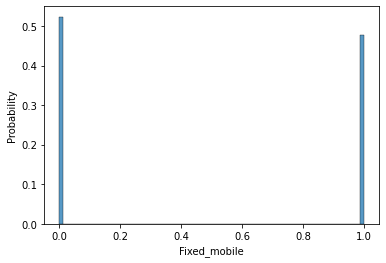

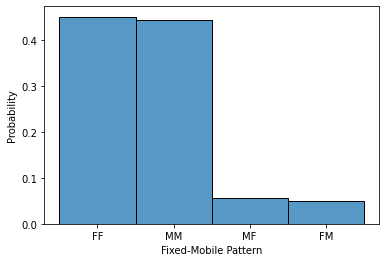

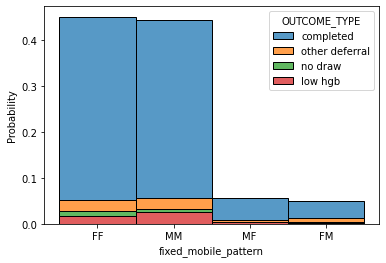

0.040487000400796336
0.055735750845320564
2435152
2671176


In [8]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
#sns.histplot(df, x="Fixed", stat="probability")
#sns.countplot(fixed)
#print(fixed.value_counts())

# group and remove some categories that are not fixed or mobile
# administrative site and apheresis clinic fall under fixed
# exclude others

df.drop(df[(df['Fixed']== 'Lapsed Clinic') | (df['Fixed']=='Processing Lab')| (df['Fixed']=='Unallocated') 
           | (df["Fixed"]== 'Laboratorium') |(df["Fixed"]=='Doctor')].index, inplace=True)

df['Fixed_mobile'] = np.where(df['Fixed'] == 'Mobile Clinic', 0, 1) #mobile is 0, fixed is 1
sns.histplot(df, x="Fixed_mobile", stat="probability")

#create a column to indicate 
    #1. mobile then mobile - mm
    #2. mobile then fixed -mf
    #3. fixed then fixed - ff
    #4. fixed then mobile - fm

df["FIXED_NEXT"] = np.where(df['DonorID'] == df['DonorID'].shift(-1), df['Fixed_mobile'].shift(-1), 10)
df.loc[((df['FIXED_NEXT']== 1) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FF'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MM'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FM'

df.loc[((df['FIXED_NEXT']==1) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MF'
df['fixed_mobile_pattern'].fillna('last', inplace=True)


#Plot fixed pattern
#create value count

df2 = df[df['fixed_mobile_pattern'] != 'last']
plt.figure()
g=sns.histplot(df2, x=df2["fixed_mobile_pattern"], stat="probability")
#plt.legend(title='Fixed-Mobile Pattern', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
plt.xlabel('Fixed-Mobile Pattern')
plt.show(g)


# the % of each fixed mobile pattern resulting in hemoglobin deferral or other deferral
plt.figure()
i=sns.histplot(data=df2, x="fixed_mobile_pattern", hue="OUTCOME_TYPE", stat = 'probability',binwidth=1, multiple="stack")
#plt.legend(title='Fixed vs Mobile by Year', loc='upper left', labels=['Mobile', 'Fixed'])
plt.show(i)

print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 1))])/len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 0))])/len(df.loc[(df['Fixed_mobile']==0)]))

print(len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[(df['Fixed_mobile']==0)]))


In [9]:
# Compute donation product for deferred donors - using the following criteria
 # 1) if donor only has WB then deferred donation is WB
 # 2) if next donation procedure is WB then deferred donation is WB/
 # 3) if previous donation procedure is WB then deferred donation is WB/
 # 4) if only donated one time and got deferred - WB
 
#prev successful 
#next successful

#df["don_proc_next"] = df.groupby("DonorID")["donation_product"].transform("shift")


df_don_proc=df.groupby("DonorID")["donation_product"].apply(list)
df["index"]=df.groupby("DonorID").cumcount()
df=pd.merge(df, df_don_proc, on="DonorID")

#missing=df.query("don_proc_imputed == 'DEF PROD'")
#len(missing)

#print(df['donation_product_x'].value_counts())


In [10]:

#keep only wb and drbc or rbc
wb=['WB', "DEF PROD", 'WBSB', 'WBMED', 'RBCAPH']
df= df.loc[(df['donation_product_x'] == 'WB') | (df['donation_product_x']== 'RBCAPH')|(df['donation_product_x'] == 'DEF PROD')
           |(df['donation_product_x'] == 'WBSB')| (df['donation_product_x'] == 'WBMED')| (df['donation_product_x'] == 'WBDISC')
           |( df['donation_product_x'] == 'WBOB') |(df['donation_product_x'] == 'WBDP') | (df['donation_product_x'] == 'WBD')]
df['donation_product_x'].value_counts()

WB          4341745
DEF PROD     546522
WBSB          75317
WBMED         12342
RBCAPH         7533
WBDISC         1085
WBOB            389
WBDP            381
WBD             204
Name: donation_product_x, dtype: int64

In [11]:
#change all above to just WB
df.loc[(df['donation_product_x'] == 'WB')|
           (df['donation_product_x'] == 'WBSB')| (df['donation_product_x'] == 'WBMED')| (df['donation_product_x'] == 'WBDISC')
           |( df['donation_product_x'] == 'WBOB') |(df['donation_product_x'] == 'WBDP') | (df['donation_product_x'] == 'WBD'),
           'donation_product_x']='WB'

In [12]:
#add time from elibilty until mobile drives repeat 
# ADD NUMBER OF MOBILE DRIVES REPEATS IN 1 YEAR PERIOD STARTING FROM TIME OF ELIGIBILITY

In [13]:
#remove outcomes with def_end < visit_date
df.drop(df[df['Visit_Date'] > df['Def_end']].index, inplace=True)

# add variable first time -> 1- first time, 0-repeat

df['first_time'] = np.where(df['index'] == 0, 1, 0)

In [14]:
#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)
df.drop(df[(df['OUTCOME_TYPE'] == 'other deferral') & (df['Deferral_permanent'] == 'NoDeferral')].index, inplace=True)

dfhgb=df.query("OUTCOME_TYPE == 'low hgb'")
dfhgb.head(50)



,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,MobileID,donation_product_x,DonProc,Outcome,ABO_RH,Disease_marker_results,HB_Value,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,FIXED_NEXT,fixed_mobile_pattern,Year-month,index,donation_product_y,first_time
67,18381,2016-08-12,2016.0,8.0,1546.0,49.0,58.0,53.7,F,Fixed Clinic,GTD003,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,NaN,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-08-12 00:00:00.000,2016-11-10 00:00:00.000,Temp,2016.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,95.0,1,1.0,FF,2016-08,7,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0
74,18381,2018-01-10,2018.0,1.0,1645.0,55.0,71.0,55.1,F,Fixed Clinic,GQD002,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,11.4,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-01-10 00:00:00.000,2018-04-10 00:00:00.000,Temp,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,105.0,1,1.0,FF,2018-01,14,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0
75,18381,2018-04-25,2018.0,4.0,1625.0,55.0,71.0,55.4,F,Fixed Clinic,GQD002,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.2,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-04-25 00:00:00.000,2018-07-24 00:00:00.000,Temp,2018.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,154.0,1,1.0,FF,2018-04,15,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0
171,18406,2021-07-06,2021.0,7.0,1525.0,35.0,87.0,66.1,M,Mobile Clinic,EWE025,DEF PROD,DEFERRAL,DEFERRAL,ONEG,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb004 - Hb Fail (M Fpm) < 12.5,2021-07-06 00:00:00.000,2022-01-02 00:00:00.000,Temp,2021.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,182.0,0,0.0,MM,2021-07,20,"[WB, WBSB, WB, WB, WB, WB, WB, WB, WB, WB, WB,...",0
225,18500,2018-12-07,2018.0,12.0,929.0,50.0,77.0,44.3,F,Mobile Clinic,GGE200,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-12-07 00:00:00.000,2019-03-07 00:00:00.000,Temp,2018.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,119.0,0,0.0,MM,2018-12,19,"[WB, WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB,...",0
251,18514,2018-09-03,2018.0,9.0,1335.0,80.0,56.0,42.9,F,Fixed Clinic,GED003,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-09-03 00:00:00.000,2018-12-02 00:00:00.000,Temp,2018.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,121.0,1,1.0,FF,2018-09,12,"[DEF PROD, WB, WB, WB, WB, WB, WB, WB, WB, WB,...",0
274,18517,2015-06-29,2015.0,6.0,1635.0,23.0,140.0,64.2,F,Fixed Clinic,MGD001,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,10.7,1,White,0.0,Haematocrit/Haemoglobin,Hb002 - Hb Fail (F < 50) 10.5 - <11.0,2015-06-29 00:00:00.000,2015-12-26 00:00:00.000,Temp,2015.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,196.0,1,1.0,FF,2015-06,2,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0
275,18517,2016-01-11,2016.0,1.0,1637.0,23.0,140.0,64.7,F,Administrative Site,MGA008,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.1,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-01-11 00:00:00.000,2016-04-10 00:00:00.000,Temp,2016.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,154.0,1,1.0,FF,2016-01,3,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0
277,18517,2016-10-12,2016.0,10.0,1633.0,23.0,140.0,65.5,F,Administrative Site,MGA008,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,11.8,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-10-12 00:00:00.000,2017-01-10 00:00:00.000,Temp,2016.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,140.0,1,1.0,FF,2016-10,5,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0
280,18517,2017-10-25,2017.0,10.0,1615.0,25.0,89.0,66.5,F,Fixed Clinic,MGD001,DEF PROD,DEF

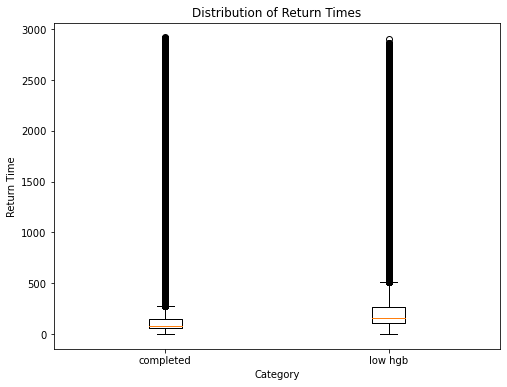

0


In [15]:
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()

df_end=df.loc[df['time_to_return'] <0]
print(len(df_end))


In [16]:
#compute time_to_return with shifts for completed donation: subtract 56 days 
df['time_to_return2']=df['time_to_return']

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return2'] - 56), df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")
df['def_Year'] = df['Def_end'].dt.year  
#df['Def_end'].isna().sum()

#hgb deferrals
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'low hgb') & (df['def_Year']< 2023) , (df['time_to_return2'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

#other deferrals
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'other deferral') & (df['def_Year'] < 2023), (df['time_to_return2'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

df['time_to_return']=np.where((df['time_to_return'] < 0) , df['time_to_return2'], df['time_to_return'])


In [17]:
# documenting some errors in data

df['time_to_return'].isnull().sum()

dfhgb=df.query("OUTCOME_TYPE == 'low hgb'")
dfhgb.head(50)


#df_end=df.loc[df['Visit_Date'] > df['Def_end']]
#print(len(df_end))
#df_end.head(25).to_csv('../4_output/def_end_error.csv')

#df_def=df.loc[(df['Deferral_permanent'] == 'NoDeferral') & (df['OUTCOME_TYPE'] == "other deferral")]
#df_def.head(25).to_csv('../4_output/def_permanent_error.csv')

#df_neg=df.loc[ (df['time_to_return']<0)]
#print(len(df_neg))
#df_neg.head(-25)



,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,MobileID,donation_product_x,DonProc,Outcome,ABO_RH,Disease_marker_results,HB_Value,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,FIXED_NEXT,fixed_mobile_pattern,Year-month,index,donation_product_y,first_time,time_to_return2,def_Year
67,18381,2016-08-12,2016.0,8.0,1546.0,49.0,58.0,53.7,F,Fixed Clinic,GTD003,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,NaN,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-08-12 00:00:00.000,2016-11-10,Temp,2016.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,5.0,1,1.0,FF,2016-08,7,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0,95.0,2016.0
74,18381,2018-01-10,2018.0,1.0,1645.0,55.0,71.0,55.1,F,Fixed Clinic,GQD002,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,11.4,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-01-10 00:00:00.000,2018-04-10,Temp,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,15.0,1,1.0,FF,2018-01,14,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0,105.0,2018.0
75,18381,2018-04-25,2018.0,4.0,1625.0,55.0,71.0,55.4,F,Fixed Clinic,GQD002,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.2,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-04-25 00:00:00.000,2018-07-24,Temp,2018.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,64.0,1,1.0,FF,2018-04,15,"[WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB, WB,...",0,154.0,2018.0
171,18406,2021-07-06,2021.0,7.0,1525.0,35.0,87.0,66.1,M,Mobile Clinic,EWE025,DEF PROD,DEFERRAL,DEFERRAL,ONEG,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb004 - Hb Fail (M Fpm) < 12.5,2021-07-06 00:00:00.000,2022-01-02,Temp,2021.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,2.0,0,0.0,MM,2021-07,20,"[WB, WBSB, WB, WB, WB, WB, WB, WB, WB, WB, WB,...",0,182.0,2022.0
225,18500,2018-12-07,2018.0,12.0,929.0,50.0,77.0,44.3,F,Mobile Clinic,GGE200,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-12-07 00:00:00.000,2019-03-07,Temp,2018.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,29.0,0,0.0,MM,2018-12,19,"[WB, WB, WB, WB, WB, WB, WB, WB, DEF PROD, WB,...",0,119.0,2019.0
251,18514,2018-09-03,2018.0,9.0,1335.0,80.0,56.0,42.9,F,Fixed Clinic,GED003,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.3,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2018-09-03 00:00:00.000,2018-12-02,Temp,2018.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,31.0,1,1.0,FF,2018-09,12,"[DEF PROD, WB, WB, WB, WB, WB, WB, WB, WB, WB,...",0,121.0,2018.0
274,18517,2015-06-29,2015.0,6.0,1635.0,23.0,140.0,64.2,F,Fixed Clinic,MGD001,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,10.7,1,White,0.0,Haematocrit/Haemoglobin,Hb002 - Hb Fail (F < 50) 10.5 - <11.0,2015-06-29 00:00:00.000,2015-12-26,Temp,2015.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,16.0,1,1.0,FF,2015-06,2,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0,196.0,2015.0
275,18517,2016-01-11,2016.0,1.0,1637.0,23.0,140.0,64.7,F,Administrative Site,MGA008,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,12.1,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-01-11 00:00:00.000,2016-04-10,Temp,2016.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,64.0,1,1.0,FF,2016-01,3,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0,154.0,2016.0
277,18517,2016-10-12,2016.0,10.0,1633.0,23.0,140.0,65.5,F,Administrative Site,MGA008,DEF PROD,DEFERRAL,DEFERRAL,OPOS,NEG,11.8,1,White,0.0,Haematocrit/Haemoglobin,Hb001 - Hb Fail (F < 50) 11 - < 12.5,2016-10-12 00:00:00.000,2017-01-10,Temp,2016.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low hgb,1,50.0,1,1.0,FF,2016-10,5,"[DEF PROD, WB, DEF PROD, DEF PROD, DEF PROD, D...",0,140.0,2017.0
280,18517,2017-10-25,2017.0,10.0,1615.0,25.0,89.0,66.5,F,Fixed Clinic,MGD00

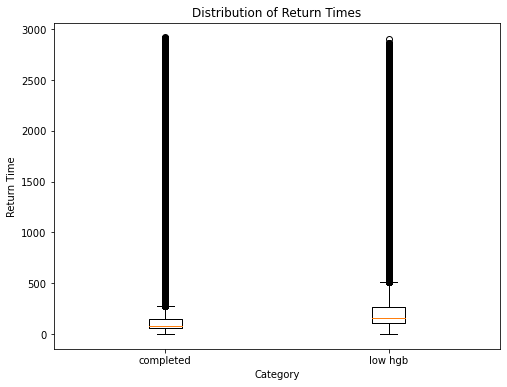

,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,MobileID,donation_product_x,DonProc,Outcome,ABO_RH,Disease_marker_results,HB_Value,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,FIXED_NEXT,fixed_mobile_pattern,Year-month,index,donation_product_y,first_time,time_to_return2,def_Year


In [18]:
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return2'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return2']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()


df_end=df.loc[df['time_to_return2'] <0]
df_end.head()
#print(len(df_end))


In [19]:

dfhgb=df_end.query("OUTCOME_TYPE == 'low hgb'")
dfhgb.head(50)

#df.drop(df[(df['time_to_return2'] < 1)].index, inplace=True)

#df_end=dfhgb.loc[dfhgb['time_to_return2'] < -100]
#print(len(df_end))


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,MobileID,donation_product_x,DonProc,Outcome,ABO_RH,Disease_marker_results,HB_Value,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,FIXED_NEXT,fixed_mobile_pattern,Year-month,index,donation_product_y,first_time,time_to_return2,def_Year


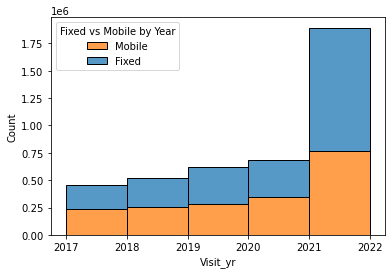

C:\Users\hjagirdar\AppData\Local\Temp\ipykernel_2668\2274193907.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=x_dates, rotation=90, ha='right', fontsize=5)


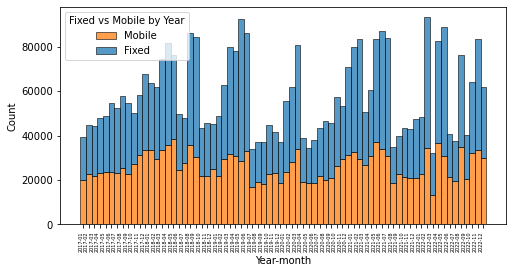

In [29]:
mask = (df['Visit_yr'] >= 2017) 
df = df.loc[mask]

plt.figure()
h=sns.histplot(data=df, x="Visit_yr", hue="Fixed_mobile", binwidth=1, multiple="stack")
plt.legend(title='Fixed vs Mobile by Year', loc='upper left', labels=['Mobile', 'Fixed'])
plt.show(h)

df['Visit_Date'] = pd.to_datetime(df.Visit_Date, format='%Y-%m-%d')
df['Year-month']= df['Visit_Date'].dt.strftime('%Y-%m')

plt.figure(figsize=(8,4))
g=sns.histplot(data=df, x="Year-month", hue="Fixed_mobile", binwidth=1, multiple="stack")
plt.legend(title='Fixed vs Mobile by Year', loc='upper left', labels=['Mobile', 'Fixed'])

x_dates = df['Year-month'].sort_values().unique()
g.set_xticklabels(labels=x_dates, rotation=90, ha='right', fontsize=5)

plt.show(g)


In [94]:
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)
